In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from my_models_gc import my_ResNet_CNN_gc
import random

def overlay_heatmap_on_image(image, heatmap):
    # Ensure heatmap is 2D (H, W) shape after resizing
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # Check if heatmap shape is correct
    # print('Heatmap shape:', heatmap.shape)
    if len(heatmap.shape) != 2:
        raise ValueError(f"Unexpected heatmap shape: {heatmap.shape}")

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    # print('Image shape:', image.shape)
    # Ensure heatmap_colored and image have the same shape
    if heatmap_colored.shape != image.shape:
        raise ValueError(f"Shapes of heatmap_colored {heatmap_colored.shape} and image {image.shape} are not the same.")

    superimposed_img = (0.4 * heatmap_colored + 0.6 * image).astype(np.uint8)
    return superimposed_img

def display_image_with_heatmap(image, heatmap):
    image_np = np.array(image).transpose(0, 1, 2)
    overlay_heatmap_on_image(image_np, heatmap)



/home/fabspace/anaconda3/envs/EzerM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'Non-SMA': 0, 'SMA': 1}


/tmp/ipykernel_796206/3759651324.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


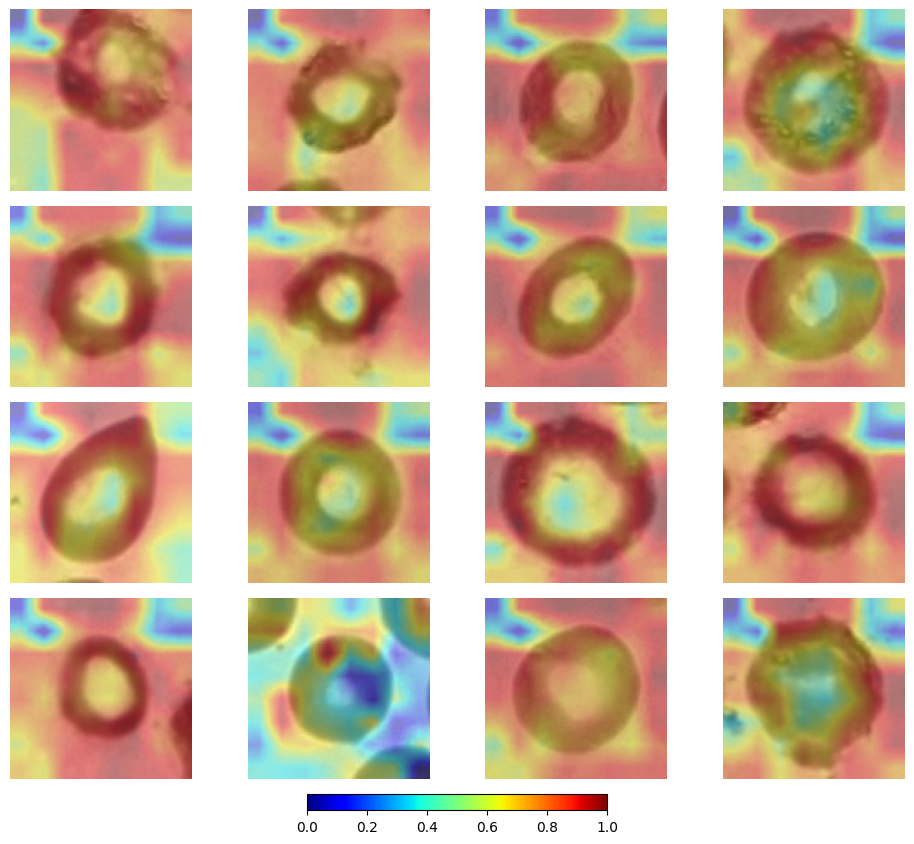

In [4]:
np.random.seed(31)
torch.manual_seed(31)
random.seed(31)

# 1. Define the dataset and dataloader
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
#    transforms.RandomRotation(90),
#    transforms.ColorJitter(),
    transforms.ToTensor()
])

root_dir = 'old/Red_Cell_Morphology_clean/SMA_cells/labelled'  # Replace with your path
datasets = ImageFolder(root_dir, transform=data_transforms)
dataloader = DataLoader(datasets, batch_size=1, shuffle=True, num_workers=1)
print(datasets.class_to_idx)

# MILSMA 4-4
model_path = 'Experiments_log/20230811_024433/model_weights_4.pth'

# MILSMA 12-3
#model_path = 'Experiments_log/20230811_024433/model_weights_4.pth'

# 2. Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = my_ResNet_CNN_gc()
model.load_state_dict(torch.load(model_path))
model.eval()
model = model.to(device)




# Create a figure to hold the 10x10 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
axes = axes.ravel()  # Flatten the 10x10 grid to easily iterate over it

# Set the max number of images to display
max_images = 16
current_image = 0

cax = None  # Variable to store the colorbar axis
for i, (inputs, labels) in enumerate(dataloader):
    if current_image >= max_images:
        break

for i, (inputs, labels) in enumerate(dataloader):
    if current_image >= max_images:
        break
    
    # inputs=inputs.unsqueeze(0)
    inputs_pred=inputs.unsqueeze(0)
    inputs_pred=inputs_pred.to(device)
    inputs = inputs.to(device)
    
    # Predict using the model
    outputs = model(inputs_pred, mode='test')

    predicted = outputs.data.round().int().squeeze(0)

    predicted_class = "1" if predicted.item() == 1 else "0"

    # Compute GradCAM+ heatmap
    grad_cam_plus = model.compute_gradcam_plus(inputs)
    
    # Convert heatmap to numpy array
    heatmap_np = grad_cam_plus.cpu().detach().numpy().squeeze()

    # Get the actual class label from the dataset
    # print(labels)
    actual_label = "1" if labels[0].item() == 1 else "0"

    # Display original image along with heatmap
    image = transforms.ToPILImage()(inputs.cpu().squeeze())
    image_np = np.array(image).transpose(0, 1, 2)
    superimposed_img = overlay_heatmap_on_image(image_np, heatmap_np)
    
    # Display predicted and actual class side by side
    #display_label = f"Actual: {actual_label} | Predicted: {predicted_class}"
    
    axes[current_image].imshow(superimposed_img)
    #axes[current_image].set_title(display_label)
    axes[current_image].axis("off")

    current_image += 1

# Create an axis dedicated to the colorbar below the images
cbar_ax = fig.add_axes([0.35, -0.02, 0.3, 0.02])  # x, y, width, height

# Use the last heatmap as a reference for the colorbar
norm = plt.Normalize(heatmap_np.min(), heatmap_np.max())
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])  # this line is necessary because of how ScalarMappable works

plt.colorbar(sm, orientation='horizontal', cax=cbar_ax)
plt.tight_layout()
plt.show()